In [1]:
import torch
from transformers import Owlv2Processor, Owlv2ForObjectDetection
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import requests
from PIL import Image
from io import BytesIO
import sys
from GetIMG import get_pictures, goto_topview, goto_sideview, topview_vec, get_frames
# sys.path.append("../")
from magpie import realsense_wrapper as real
from magpie.ur5 import UR5_Interface as robot
from magpie_perception.label_owlv2 import LabelOWLv2
import numpy as np
import pyrealsense2 as rs
import random
import time
import json


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
myrs = real.RealSense()
myrs.initConnection()
myrobot = robot()
myrobot.start()
label_vit = LabelOWLv2(topk=1, score_threshold= 0.2, cpu_override=False)


Found Dynamixel Port:
/dev/ttyACM0

Succeeded to open the port
Succeeded to change the baudrate
Moving speed of dxl ID: 1 set to 100 
Moving speed of dxl ID: 2 set to 100 


In [3]:
myrobot.open_gripper()


Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 


In [4]:
from openai import OpenAI
import requests
import base64
import io
from config import API_KEY


client = OpenAI(
    api_key= API_KEY,
)

#Function that takes a list of blocks in order of the tower [red, green, blue] and produces a prompt to be given to the GPT4o in sideview
def set_prompt(str_list_stack_order):
    input_str = (f"""You are a block stacking robot, your job is to take an order of blocks to build a tower and an image of the current state of blocks.
                  Then you should output a json with entries for pick:color of 'block', place:color of "block" to place picked block on top of 
                  if you do not want to place a block on the table there is a "black square" you can place blocks on but not pickup, 
                 and Done:0/1 when the tower is complete.
                  Give me the next instruction so the blocks are stacked from bottom to top in order {str_list_stack_order}
                when the current state is in the image provided
                OUTPUT ONLY JSON for a single next instruction and 
                thats it no more text just a json. make sure to use the word block in pick and place if its not the black square.
                We are building the tower on the table and the black square is only used for storage.""")
    return input_str

#helper function that formats the image for GPT api
def ndarray_to_base64(ndarray):
    # Convert the ndarray to a PIL Image
    image = Image.fromarray(ndarray)
    
    # Create a BytesIO object to save the image
    buffered = io.BytesIO()
    image.save(buffered, format="JPEG")  # Specify the format you want
    # Get the byte data and encode to base64
    encoded_string = base64.b64encode(buffered.getvalue()).decode('utf-8')
    
    return encoded_string

#api calling function
def get_response(str_prompt, img_prompt):
    image = ndarray_to_base64(img_prompt)
    img_type = "image/jpeg"
    # Save the image to a file
    response = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": str_prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:{img_type};base64,{image}"},
                    },
                ],
            }
        ],
    ) 
    dict_resp = response.to_dict()
    message = dict_resp['choices'][0]['message']["content"]
    first_bracket = message.index("{")
    second_bracket = message.index("}")
    # Extract the JSON string
    json_string = message[first_bracket:second_bracket + 1]

    # Parse the JSON string into a Python dictionary
    json_instruction = json.loads(json_string)

    #print(json_instruction)
    return response, json_instruction




In [5]:
output_str = set_prompt(["red", "blue", "green"])
print(output_str)

You are a block stacking robot, your job is to take an order of blocks to build a tower and an image of the current state of blocks.
                  Then you should output a json with entries for pick:color of 'block', place:color of "block" to place picked block on top of 
                  if you do not want to place a block on the table there is a "black square" you can place blocks on but not pickup, 
                 and Done:0/1 when the tower is complete.
                  Give me the next instruction so the blocks are stacked from bottom to top in order ['red', 'blue', 'green']
                when the current state is in the image provided
                OUTPUT ONLY JSON for a single next instruction and 
                thats it no more text just a json. make sure to use the word block in pick and place if its not the black square.
                We are building the tower on the table and the black square is only used for storage.


sideview_vec=[0.0360674358115564, -0.20624107287146376, 0.2646274319314355, 1.8434675848139614, 1.4569842711938066, -1.2315497051361715]
sideview_matrix=SE3(array([[ 0.026,  0.937, -0.35 ,  0.036],
           [ 0.501, -0.315, -0.806, -0.206],
           [-0.865, -0.154, -0.477,  0.265],
           [ 0.   ,  0.   ,  0.   ,  1.   ]]))


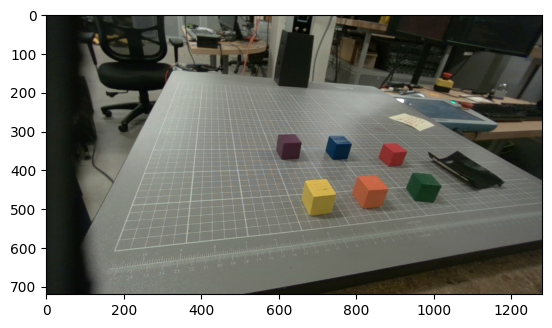

In [6]:
goto_sideview(myrobot, asynch = False)
rgb_img, depth_img = get_pictures(myrs)
plt.figure()
plt.imshow(rgb_img)
plt.show()

#pick, place = pick_place_BB("green block", "blue block" , rgb_img, plot_bool=True)
#pick_block_str, place_block_str = prompt_planning_LLM(prompt, rgb_img)
#pick_block_str, place_block_str = "blue block", "red block"
#test = get_location_bbox(["green block","blue block"], pick, rgb_img)


In [7]:
##--string for GPT QUERY--##
output_str = set_prompt(["red", "blue", "green"])
print(output_str)

##--GPT QUERY--##

"""
gptresp, instruction = get_response(output_str, rgb_img)
print(gptresp)
print(instruction)
"""


You are a block stacking robot, your job is to take an order of blocks to build a tower and an image of the current state of blocks.
                  Then you should output a json with entries for pick:color of 'block', place:color of "block" to place picked block on top of 
                  if you do not want to place a block on the table there is a "black square" you can place blocks on but not pickup, 
                 and Done:0/1 when the tower is complete.
                  Give me the next instruction so the blocks are stacked from bottom to top in order ['red', 'blue', 'green']
                when the current state is in the image provided
                OUTPUT ONLY JSON for a single next instruction and 
                thats it no more text just a json. make sure to use the word block in pick and place if its not the black square.
                We are building the tower on the table and the black square is only used for storage.


'\ngptresp, instruction = get_response(output_str, rgb_img)\nprint(gptresp)\nprint(instruction)\n'

In [8]:
def parse_gpt(response):
    content = response[3]
    

In [9]:
def get_depth_frame_intrinsics(rs_wrapper, modality = "depth"):
    rgb_frame, depth_frame = get_frames(rs_wrapper)
    intrinsics = depth_frame.profile.as_video_stream_profile().intrinsics
    return depth_frame, intrinsics

def get_topview_depth(x, y, UR_interface, rs_wrapper):
    goto_topview(UR_interface, asynch = False)
    n_samples = 50
    valid_samples = 0
    depth_measurements = []
    intrinsics = None
    for i in range(n_samples):
        depth_frame, intrinsics = get_depth_frame_intrinsics(rs_wrapper)
        depth_val = depth_frame.get_distance(x, y)  # in meters
        if depth_val > 0:
            depth_measurements.append(depth_val)
    depth_measurements = np.array(depth_measurements)
    std = np.std(depth_measurements)
    mean = np.mean(depth_measurements)
    in_std_mask = np.abs(depth_measurements-mean) <= std
    depth_measurements = depth_measurements[in_std_mask]
    #print(f"{depth_measurements=}")
    depth_val = sum(depth_measurements)/len(depth_measurements)
    #print(f"{depth_val=}")
    assert depth_val > 0, f"not able to get depth val after {n_samples} samples {depth_val=}"
    return depth_val, intrinsics

def deproject_top_view_point(UR_interface, rs_wrapper, pixel_x, pixel_y):
    depth, K = get_topview_depth(pixel_x, pixel_y, UR_interface, rs_wrapper)
    return rs.rs2_deproject_pixel_to_point(K, [pixel_x, pixel_y], depth)

def calc_topview_side_length(bb, UR_interface, rs_wrapper):
    LL_X, LL_Y, LL_Z = deproject_top_view_point( UR_interface, rs_wrapper, bb['xmin'], bb['ymin'])
    LR_X, LR_Y, LR_Z = deproject_top_view_point( UR_interface, rs_wrapper, bb['xmax'], bb['ymin'])
    sidelength = (LL_X-LR_X)**2
    sidelength += (LL_Y-LR_Y)**2
    sidelength += (LL_Z-LR_Z)**2
    sidelength = np.sqrt(sidelength)
    return sidelength

In [10]:
"""

pick_place_BB takes the color of the block that needs to be picked up and the color of the block 
to be placed on and gives the cords of where each are located as {xmin, ymin, xmax, ymax, strlabel}

"""
def topview_pick_place_BB(UR_Interface, rs_wrapper, pick_str, place_str, plot_bool= False):
    #initlize local variables
    goto_topview(UR_Interface, asynch = False)
    rgb_img, depth_img = get_pictures(rs_wrapper)
    pick_cord_dict, place_cord_dict = {} , {}
    str_cords = ["xmin", "ymin", "xmax", "ymax"]
    queries = [pick_str, place_str]
    abbrevq = [pick_str, place_str]
    
    #pick bboxes and cords
    pick_bbox = label_vit.label(rgb_img, queries[0], abbrevq[0], plot=plot_bool, topk=True)
    pick_bbox_cords = pick_bbox[1][0].tolist()
    for pick , cord in zip(pick_bbox_cords, str_cords):
        pick_cord_dict[cord] = int(pick)
    pick_cord_dict["strlabel"] = pick_str
    pick_cord_dict["xCenter"] = int((pick_cord_dict['xmin'] + pick_cord_dict["xmax"])/2)
    pick_cord_dict["yCenter"] = int((pick_cord_dict['ymin'] + pick_cord_dict["ymax"])/2)
    pick_cord_dict["ImgFrameWorldCoord"] = deproject_top_view_point(UR_Interface, rs_wrapper, pick_cord_dict["xCenter"], pick_cord_dict["yCenter"])
    pick_cord_dict["sidelength"] = calc_topview_side_length(pick_cord_dict, UR_Interface, rs_wrapper)
    print(f"{pick_cord_dict=}")
    

    #place bboxes and cords
    place_bbox = label_vit.label(rgb_img, queries[1], abbrevq[1], plot=plot_bool, topk=True)
    place_bbox_cords = place_bbox[1][0].tolist()
    for pick , cord in zip(place_bbox_cords, str_cords):
        place_cord_dict[cord] = int(pick)
    place_cord_dict["strlabel"] = place_str
    place_cord_dict["xCenter"] = int((place_cord_dict['xmin'] + place_cord_dict["xmax"])/2)
    place_cord_dict["yCenter"] = int((place_cord_dict['ymin'] + place_cord_dict["ymax"])/2)
    place_cord_dict["ImgFrameWorldCoord"] = deproject_top_view_point(UR_Interface, rs_wrapper, place_cord_dict["xCenter"], place_cord_dict["yCenter"])
    place_cord_dict["sidelength"] = calc_topview_side_length(place_cord_dict, UR_Interface, rs_wrapper)
    print(f"{place_cord_dict}=")
    

    
    
    #return dictionarys with {xmin, ymin, xmax, ymax, strlabel}
    #return (pick_bbox, pick_cord_dict) , (place_bbox, place_cord_dict)
    return pick_cord_dict, place_cord_dict

   



In [11]:


#pick_bb, place_bb = topview_pick_place_BB(myrobot, myrs, pick_block_str, place_block_str, rgb_img, plot_bool=True)
#yellow_bb, red_bb = topview_pick_place_BB(myrobot, myrs, "yellow block", "red block", rgb_img, plot_bool=True)


# print(f"{type(pick)=}")
# print(f"{dir(pick)=}")
# print(f"{len(pick)=}")

# for entry in pick:
#     print(dir(entry))
#     print(type(entry))
#     print(entry)

#matplotlib plot depth image with bounding boxes and color bar metric scale


In [12]:
def pick(UR_interface, rsWrapper, bb, display=False):
    X, Y, Z = bb["ImgFrameWorldCoord"]
    print(f"Img Coordinates of Block: {X=}, {Y=}, {Z=}\n")

    #DX = topview_vec[0] - Y
    #print(f"{DX=}= {topview_vec[0]=} - {Y=}")
    new_X = topview_vec[0] - Y
    #print(f"{new_X=}= {topview_vec[0]=} +{DX=}\n")
    
    #DY = topview_vec[1] - X
    #print(f"{DY=}= {topview_vec[1]=} + {X=}")
    new_Y = topview_vec[1] - X
    #print(f"{new_Y=}= {topview_vec[1]=} +{DY=}\n")


    
    print(f"{topview_vec=}")
    goal_vec = topview_vec.copy()
    goal_vec[0] = new_X
    goal_vec[1] = new_Y + 0.01
    print(f"{goal_vec = }")
    
    goal_matrix = UR_interface.poseVectorToMatrix(goal_vec)
    UR_interface.moveL(goal_matrix, linSpeed=0.1, asynch=False)
    UR_interface.align_tcp()

    goal_z = topview_vec[2] - Z + 0.1
    goal_vec[2] = goal_z
    print(f"{goal_vec = }")

    goal_matrix = UR_interface.poseVectorToMatrix(goal_vec)
    UR_interface.moveL(goal_matrix, linSpeed=0.1, asynch=False)

    UR_interface.close_gripper()
    time.sleep(2)

    if display:
        rgb_frame, depth_frame = get_frames(rsWrapper)
        depth_image = np.asarray(depth_frame.get_data())
        plt.imshow(depth_image)
        plt.gca().add_patch(plt.Rectangle(
            (bb['xmin'], bb['ymin']),
            bb['xmax'] - bb['xmin'],
            bb['ymax'] - bb['ymin'],
            edgecolor='red',
            facecolor='none',
            linewidth=2
        ))
        circle = plt.Circle((bb['xCenter'], bb['yCenter']), 5, edgecolor='blue', facecolor='none', linewidth=2)
        plt.gca().add_patch(circle)
        plt.text(bb['xmin'], bb['ymin'] - 10, bb['strlabel'],
                color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
        plt.axis('off')  # Hide axes
        plt.show()
    
    


#pick(myrobot, myrs, pick_bb, display = True)

In [13]:
def place(UR_interface, rsWrapper, bb, display=False):
    X, Y, Z = bb["ImgFrameWorldCoord"]
    print(f"Img Coordinates of Block: {X=}, {Y=}, {Z=}\n")

    #DX = topview_vec[0] - Y
    #print(f"{DX=}= {topview_vec[0]=} - {Y=}")
    new_X = topview_vec[0] - Y
    #print(f"{new_X=}= {topview_vec[0]=} +{DX=}\n")
    
    #DY = topview_vec[1] - X
    #print(f"{DY=}= {topview_vec[1]=} + {X=}")
    new_Y = topview_vec[1] - X  + 0.01
    #print(f"{new_Y=}= {topview_vec[1]=} +{DY=}\n")
    goal_z = topview_vec[2] - Z + bb["sidelength"] + 0.0875



    
    print(f"{topview_vec=}")
    goal_vec = topview_vec.copy()
    goal_vec[0] = new_X
    goal_vec[1] = new_Y
    print(f"{goal_vec = }")
    
    goal_matrix = UR_interface.poseVectorToMatrix(goal_vec)
    UR_interface.moveL(goal_matrix, linSpeed=0.1, asynch=False)
    UR_interface.align_tcp()

    goal_vec[2] = goal_z
    print(f"{goal_vec = }")
    goal_matrix = UR_interface.poseVectorToMatrix(goal_vec)
    UR_interface.moveL(goal_matrix, linSpeed=0.1, asynch=False)

    UR_interface.open_gripper()
    time.sleep(2)


    goal_vec[2] = topview_vec[2]
    print(f"{goal_vec = }")
    goal_matrix = UR_interface.poseVectorToMatrix(goal_vec)
    UR_interface.moveL(goal_matrix, linSpeed=0.1, asynch=False)

    if display:
        rgb_frame, depth_frame = get_frames(rsWrapper)
        depth_image = np.asarray(depth_frame.get_data())
        plt.imshow(depth_img)
        plt.gca().add_patch(plt.Rectangle(
            (bb['xmin'], bb['ymin']),
            bb['xmax'] - bb['xmin'],
            bb['ymax'] - bb['ymin'],
            edgecolor='red',
            facecolor='none',
            linewidth=2
        ))
        circle = plt.Circle((bb['xCenter'], bb['yCenter']), 5, edgecolor='blue', facecolor='none', linewidth=2)
        plt.gca().add_patch(circle)
        plt.text(bb['xmin'], bb['ymin'] - 10, bb['strlabel'],
                color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
        plt.axis('off')  # Hide axes
        plt.show()
#place(myrobot, myrs, place_bb, display = True)

No LLM PLANNING

pick_cord_dict={'xmin': 559, 'ymin': 381, 'xmax': 606, 'ymax': 429, 'strlabel': 'blue block', 'xCenter': 582, 'yCenter': 405, 'ImgFrameWorldCoord': [-0.031076807528734207, 0.028847606852650642, 0.37770286202430725], 'sidelength': np.float64(0.03142356802917344)}
{'xmin': 532, 'ymin': 512, 'xmax': 581, 'ymax': 570, 'strlabel': 'red block', 'xCenter': 556, 'yCenter': 541, 'ImgFrameWorldCoord': [-0.04693169146776199, 0.11065229028463364, 0.3808909058570862], 'sidelength': np.float64(0.02996495151850809)}=
Img Coordinates of Block: X=-0.031076807528734207, Y=0.028847606852650642, Z=0.37770286202430725

topview_vec=[-0.16188220333609551, -0.6234229524443915, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.19072981018874616, -0.5823461449156573, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.19072981018874616, -0.5823461449156573, 0.26978103639740103, 1e-05, -3.141592653589793, -1e-05]
Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to

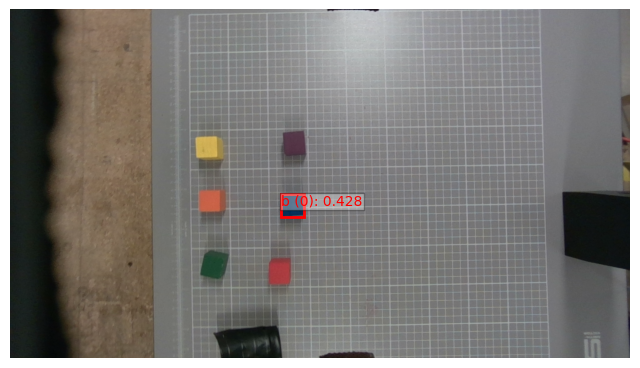

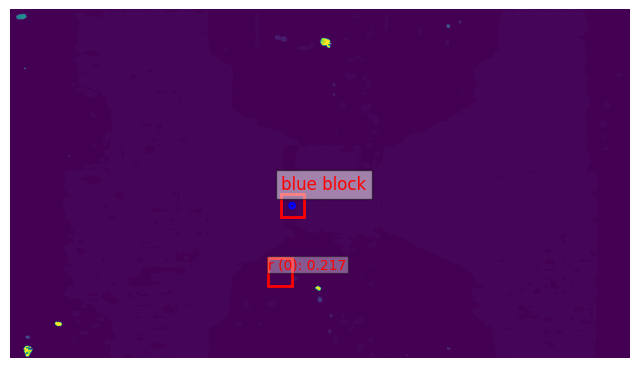

Img Coordinates of Block: X=-0.04693169146776199, Y=0.11065229028463364, Z=0.3808909058570862

topview_vec=[-0.16188220333609551, -0.6234229524443915, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.2725344936207291, -0.5664912609766295, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.2725344936207291, -0.5664912609766295, np.float64(0.28405794408313023), 1e-05, -3.141592653589793, -1e-05]
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 
goal_vec = [-0.2725344936207291, -0.5664912609766295, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]


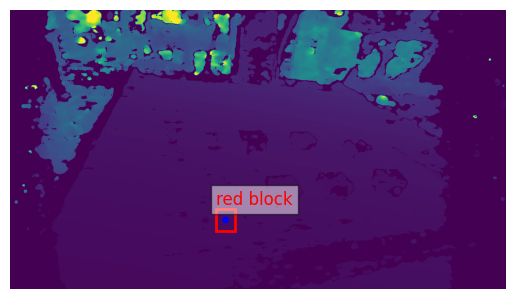

pick_cord_dict={'xmin': 394, 'ymin': 472, 'xmax': 453, 'ymax': 533, 'strlabel': 'green block', 'xCenter': 423, 'yCenter': 502, 'ImgFrameWorldCoord': [-0.12541614472866058, 0.08638344705104828, 0.37704998254776], 'sidelength': np.float64(0.03750483572663373)}
{'xmin': 527, 'ymin': 524, 'xmax': 590, 'ymax': 593, 'strlabel': 'blue block', 'xCenter': 558, 'yCenter': 558, 'ImgFrameWorldCoord': [-0.04503396525979042, 0.11900217831134796, 0.37507498264312744], 'sidelength': np.float64(0.03948550313451702)}=
Img Coordinates of Block: X=-0.12541614472866058, Y=0.08638344705104828, Z=0.37704998254776

topview_vec=[-0.16188220333609551, -0.6234229524443915, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.2482656503871438, -0.4880068077157309, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.2482656503871438, -0.4880068077157309, 0.27043391587394827, 1e-05, -3.141592653589793, -1e-05]
Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 


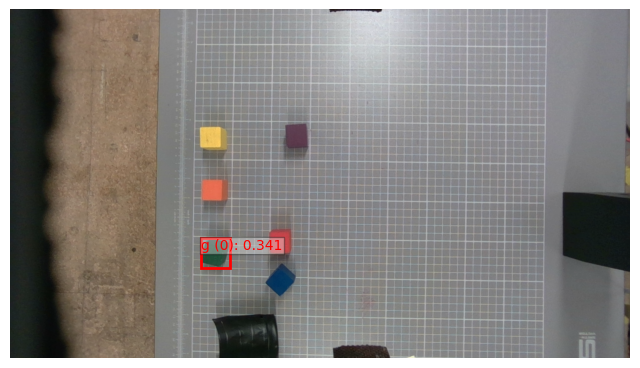

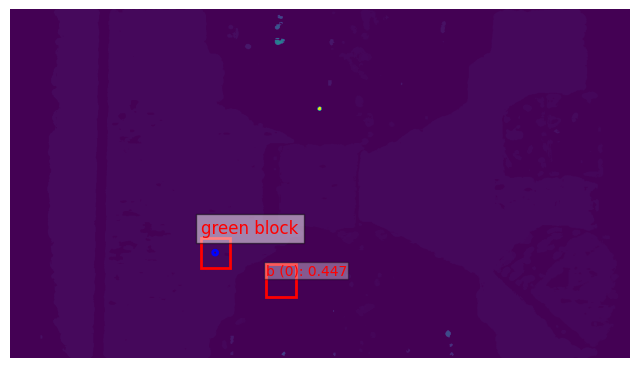

Img Coordinates of Block: X=-0.04503396525979042, Y=0.11900217831134796, Z=0.37507498264312744

topview_vec=[-0.16188220333609551, -0.6234229524443915, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.28088438164744345, -0.5683889871846011, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.28088438164744345, -0.5683889871846011, np.float64(0.29939441891309787), 1e-05, -3.141592653589793, -1e-05]
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 
goal_vec = [-0.28088438164744345, -0.5683889871846011, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]


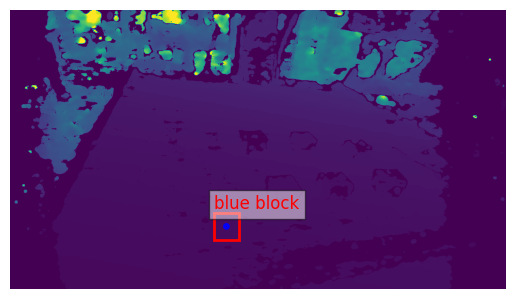

pick_cord_dict={'xmin': 393, 'ymin': 236, 'xmax': 450, 'ymax': 287, 'strlabel': 'yellow block', 'xCenter': 421, 'yCenter': 261, 'ImgFrameWorldCoord': [-0.12645910680294037, -0.05662566050887108, 0.37661999464035034], 'sidelength': np.float64(0.03638335613412673)}
{'xmin': 525, 'ymin': 536, 'xmax': 579, 'ymax': 597, 'strlabel': 'green block', 'xCenter': 552, 'yCenter': 566, 'ImgFrameWorldCoord': [-0.04592591151595116, 0.11697351932525635, 0.35460302233695984], 'sidelength': np.float64(0.03404830316699672)}=
Img Coordinates of Block: X=-0.12645910680294037, Y=-0.05662566050887108, Z=0.37661999464035034

topview_vec=[-0.16188220333609551, -0.6234229524443915, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.10525654282722444, -0.4869638456414511, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.10525654282722444, -0.4869638456414511, 0.27086390378135794, 1e-05, -3.141592653589793, -1e-05]
Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set

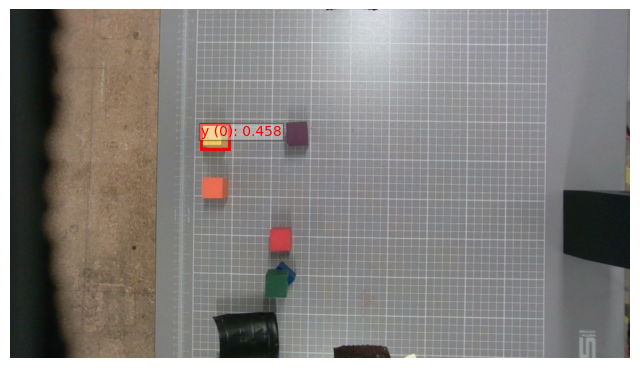

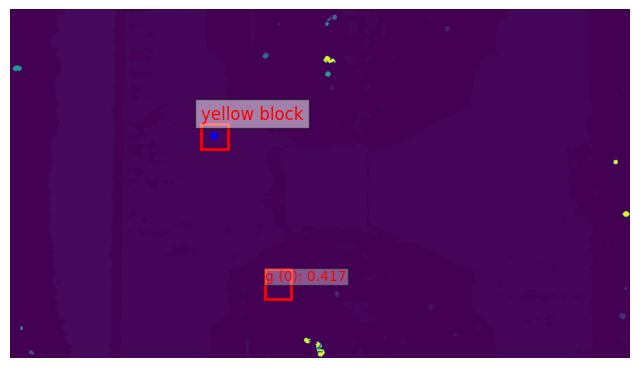

Img Coordinates of Block: X=-0.04592591151595116, Y=0.11697351932525635, Z=0.35460302233695984

topview_vec=[-0.16188220333609551, -0.6234229524443915, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.27885572266135183, -0.5674970409284403, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.27885572266135183, -0.5674970409284403, np.float64(0.3144291792517452), 1e-05, -3.141592653589793, -1e-05]
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 
goal_vec = [-0.27885572266135183, -0.5674970409284403, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]


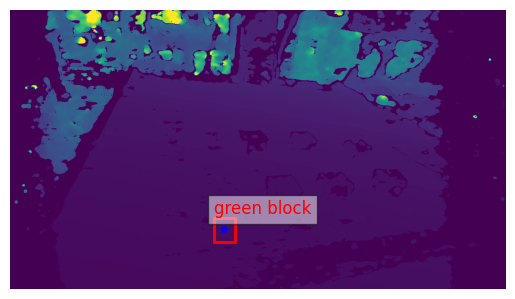

pick_cord_dict={'xmin': 569, 'ymin': 232, 'xmax': 616, 'ymax': 283, 'strlabel': 'purple block', 'xCenter': 592, 'yCenter': 257, 'ImgFrameWorldCoord': [-0.024787724018096924, -0.0583617128431797, 0.3725605905056], 'sidelength': np.float64(0.02948958521693975)}
{'xmin': 516, 'ymin': 542, 'xmax': 572, 'ymax': 609, 'strlabel': 'yellow block', 'xCenter': 544, 'yCenter': 575, 'ImgFrameWorldCoord': [-0.046063005924224854, 0.11151687055826187, 0.3241371214389801], 'sidelength': np.float64(0.0457074108342547)}=
Img Coordinates of Block: X=-0.024787724018096924, Y=-0.0583617128431797, Z=0.3725605905056

topview_vec=[-0.16188220333609551, -0.6234229524443915, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.10352049049291581, -0.5886352284262946, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.10352049049291581, -0.5886352284262946, 0.2749233079161083, 1e-05, -3.141592653589793, -1e-05]
Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 


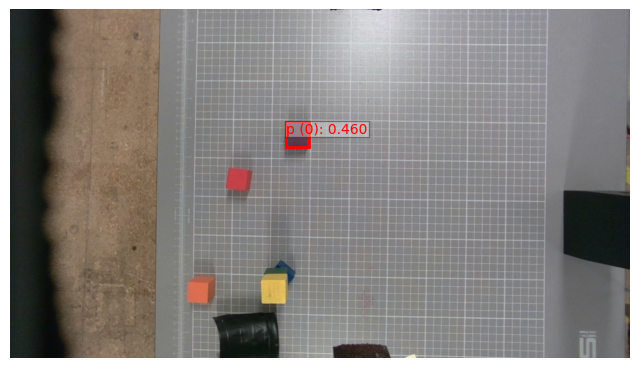

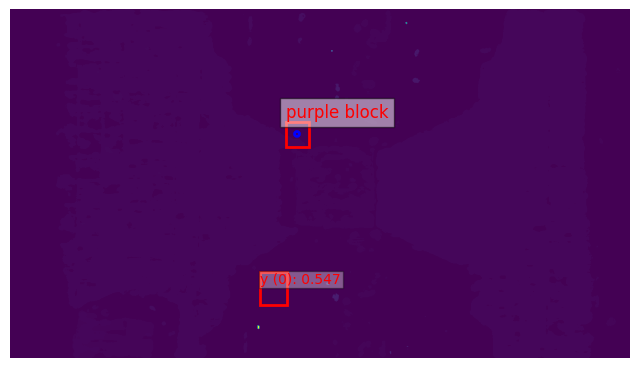

Img Coordinates of Block: X=-0.046063005924224854, Y=0.11151687055826187, Z=0.3241371214389801

topview_vec=[-0.16188220333609551, -0.6234229524443915, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.27339907389435736, -0.5673599465201666, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.27339907389435736, -0.5673599465201666, np.float64(0.3565541878169829), 1e-05, -3.141592653589793, -1e-05]
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 
goal_vec = [-0.27339907389435736, -0.5673599465201666, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]


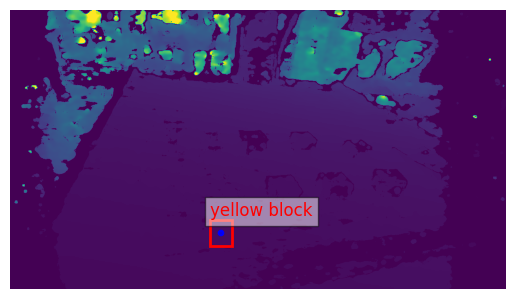

pick_cord_dict={'xmin': 373, 'ymin': 535, 'xmax': 431, 'ymax': 595, 'strlabel': 'orange block', 'xCenter': 402, 'yCenter': 565, 'ImgFrameWorldCoord': [-0.14328883588314056, 0.1286374032497406, 0.3918321430683136], 'sidelength': np.float64(0.03740151024671522)}
{'xmin': 524, 'ymin': 530, 'xmax': 589, 'ymax': 607, 'strlabel': 'purple block', 'xCenter': 556, 'yCenter': 568, 'ImgFrameWorldCoord': [-0.03742210939526558, 0.10114256292581558, 0.30371248722076416], 'sidelength': np.float64(0.04073525534447239)}=
Img Coordinates of Block: X=-0.14328883588314056, Y=0.1286374032497406, Z=0.3918321430683136

topview_vec=[-0.16188220333609551, -0.6234229524443915, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.2905196065858361, -0.4701341165612509, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.2905196065858361, -0.4701341165612509, 0.2556517553533947, 1e-05, -3.141592653589793, -1e-05]
Position of dxl ID: 1 set to 586 
Position of dxl ID: 2 set to 450 

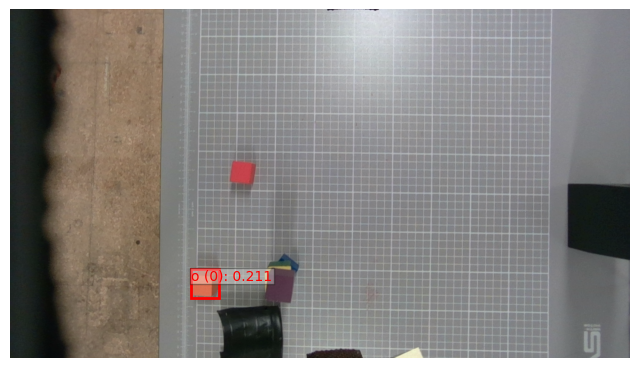

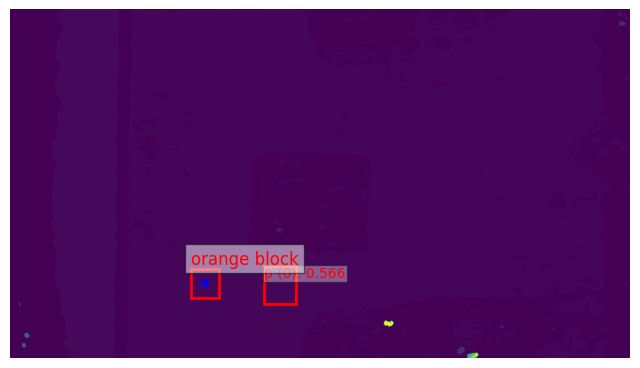

Img Coordinates of Block: X=-0.03742210939526558, Y=0.10114256292581558, Z=0.30371248722076416

topview_vec=[-0.16188220333609551, -0.6234229524443915, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.26302476626191107, -0.5760008430491259, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]
goal_vec = [-0.26302476626191107, -0.5760008430491259, np.float64(0.3720066665454166), 1e-05, -3.141592653589793, -1e-05]
Position of dxl ID: 1 set to 303 
Position of dxl ID: 2 set to 729 
goal_vec = [-0.26302476626191107, -0.5760008430491259, 0.5474838984217083, 1e-05, -3.141592653589793, -1e-05]


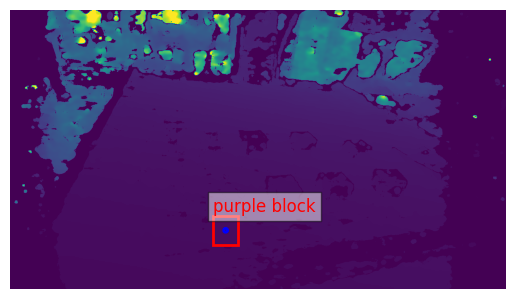

In [14]:
#myrobot.stop()
#myrs.disconnect()
tower = ["red block", "blue block", "green block", "yellow block", "purple block", "orange block"]
#tower = ["red block", "blue block", "green block"]
for i in range(0, len(tower)-1):
    pick_str= tower[i+1]
    place_str= tower[i]
    pick_bb, place_bb = topview_pick_place_BB(myrobot, myrs, pick_str, place_str, plot_bool=True)
    pick(myrobot, myrs, pick_bb, display = True)
    place(myrobot, myrs, place_bb, display = True)




YES LLM PLANNING

In [15]:
#tower = ["red block", "blue block", "green block", "yellow block", "purple block"]
tower = ["red block", "blue block", "green block"]
n_attempts = 2*len(tower)
Done = 0
i = 0
"""
while(not Done and i < n_attempts):
    i += 1
    goto_sideview(myrobot, asynch = False)
    rgb_img, depth_img = get_pictures(myrs)
    gptresp, instruction = get_response(set_prompt(tower), rgb_img)
    print(instruction)
    pick_str= instruction["pick"]
    place_str= instruction["place"]
    Done = int(instruction["Done"])
    pick_bb, place_bb = topview_pick_place_BB(myrobot, myrs, pick_str, place_str, plot_bool=True)
    pick(myrobot, myrs, pick_bb, display = True)
    place(myrobot, myrs, place_bb, display = True)
"""

'\nwhile(not Done and i < n_attempts):\n    i += 1\n    goto_sideview(myrobot, asynch = False)\n    rgb_img, depth_img = get_pictures(myrs)\n    gptresp, instruction = get_response(set_prompt(tower), rgb_img)\n    print(instruction)\n    pick_str= instruction["pick"]\n    place_str= instruction["place"]\n    Done = int(instruction["Done"])\n    pick_bb, place_bb = topview_pick_place_BB(myrobot, myrs, pick_str, place_str, plot_bool=True)\n    pick(myrobot, myrs, pick_bb, display = True)\n    place(myrobot, myrs, place_bb, display = True)\n'